In [ ]:
pip install numpy pandas matplotlib scikit-learn statsmodels yfinance

In [ ]:
pip install mplfinance

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import warnings

In [2]:
ticker_symbol = "CL=F"  # Ticker symbol for WTI crude oil futures is "CL-F", 
#le ticker "CL=F" (ou parfois √©crit "CL-F") correspond au contrat future WTI (West Texas Intermediate) le plus proche, donc g√©n√©ralement le future du mois le plus proche √† l‚Äô√©ch√©ance (le ¬´ front month ¬ª).
start_date = "2022-01-01"
end_date = "2022-12-31"

# T√©l√©chargement des donn√©es
wti_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Affichage des 5 premi√®res lignes
print(wti_data.head(5))

# Taille de l'objet (nombre de lignes et de colonnes)
print("Taille de l'objet :", wti_data.shape)

# Type de l'objet
print("Type de l'objet :", type(wti_data))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open  Volume
Ticker           CL=F       CL=F       CL=F       CL=F    CL=F
Date                                                          
2022-01-03  76.080002  76.459999  74.269997  75.690002  317628
2022-01-04  76.989998  77.639999  75.699997  76.019997  372848
2022-01-05  77.849998  78.580002  76.510002  77.180000  397898
2022-01-06  79.459999  80.239998  76.730003  77.239998  476665
2022-01-07  78.900002  80.470001  78.519997  79.620003  414434
Taille de l'objet : (251, 5)
Type de l'objet : <class 'pandas.core.frame.DataFrame'>


In [33]:
# Check for missing values
print(wti_data.isnull().sum(), wti_data.dtypes)
# Get a summary of the data
print(wti_data.describe())

Price   Ticker
Close   CL=F      0
High    CL=F      0
Low     CL=F      0
Open    CL=F      0
Volume  CL=F      0
dtype: int64 Price   Ticker
Close   CL=F      float64
High    CL=F      float64
Low     CL=F      float64
Open    CL=F      float64
Volume  CL=F        int64
dtype: object
Price        Close        High         Low        Open         Volume
Ticker        CL=F        CL=F        CL=F        CL=F           CL=F
count   251.000000  251.000000  251.000000  251.000000     251.000000
mean     94.331474   96.609562   92.034382   94.375339  322828.494024
std      12.392960   12.936314   11.770656   12.468534  120562.642963
min      71.019997   72.919998   70.080002   71.790001   58714.000000
25%      85.570000   87.050003   83.509998   85.244999  271209.000000
50%      91.930000   93.739998   90.349998   91.750000  320304.000000
75%     104.230000  106.610001  101.285000  103.994999  379503.000000
max     123.699997  130.500000  120.790001  124.660004  872244.000000


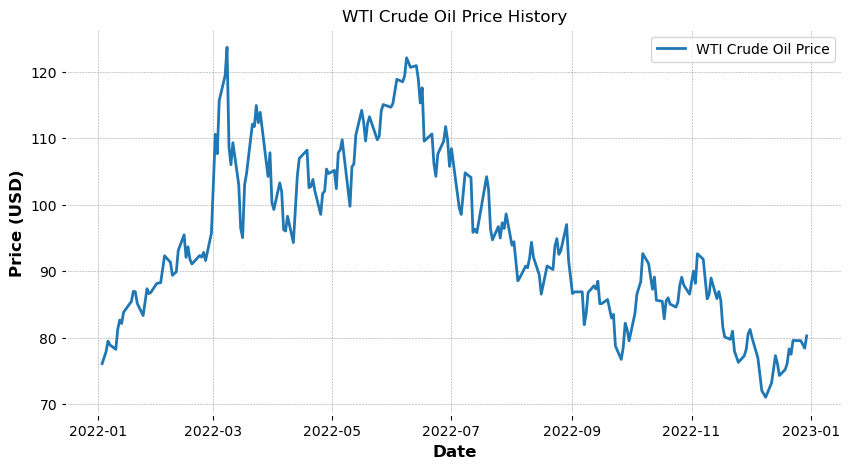

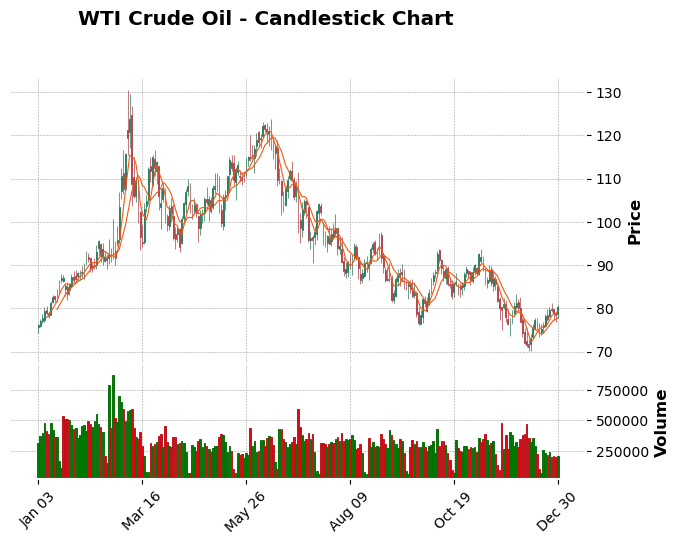

In [44]:
##Plot classique
plt.figure(figsize=(10, 5))
plt.plot(wti_data['Close'], label='WTI Crude Oil Price')
plt.title('WTI Crude Oil Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

##Plot candlestick avec la bibliotheque mplfinance qui permet de cr√©er facilement des graphiques boursiers professionnels,
# S'assurer que l'index est de type datetime (normalement c'est le cas avec yfinance)
wti_data.index = pd.to_datetime(wti_data.index)

wti_data.columns = wti_data.columns.get_level_values(0) #Aplatir les colonnes s'il y a un multi-index

#Graphe Chandelles
mpf.plot(wti_data, type='candle', style='charles', volume=True, title='WTI Crude Oil - Candlestick Chart', mav=(5,10))


## Step 4: Feature Engineering

Pour la pr√©vision de s√©ries temporelles, nous pouvons cr√©er des **features** qui aideront notre mod√®le √† faire de meilleures pr√©dictions :

1. **Cr√©er des lag features** :  
   Une lag feature est une valeur pass√©e de la s√©rie temporelle.  
   Par exemple, le prix de la veille peut √™tre un bon pr√©dicteur du prix d‚Äôaujourd‚Äôhui.

2. **Cr√©er des rolling window features** :  
   Les rolling window features, comme la moyenne mobile, permettent d‚Äôatt√©nuer les fluctuations √† court terme  
   et d‚Äôidentifier les tendances √† plus long terme.


# Cr√©er des lag features :  
**Pourquoi la m√©thode des lags est surtout adapt√©e au court terme ?**

- Les lags utilisent uniquement les valeurs pass√©es proches  
  (ex : prix d‚Äôhier, de la semaine derni√®re, du mois dernier)  
  pour pr√©dire le prix du lendemain.

- Cela fonctionne bien pour des horizons courts, car les prix sont souvent **autocorr√©l√©s √† court terme** :  
  aujourd‚Äôhui d√©pend fortement d‚Äôhier, etc.

- **Mais sur le moyen ou long terme, les dynamiques changent :**  
  - Nouveaux facteurs externes entrent en jeu (politiques, √©conomiques, g√©opolitiques).  
  - Les tendances peuvent s‚Äôinverser.  
  - Les influences non lin√©aires et complexes sont plus marqu√©es.

---

## Limitations pour les pr√©dictions √† plus long terme

- La m√©thode des lags ne capture pas ces facteurs exog√®nes et dynamiques complexes.  
- Elle est surtout une bonne base statistique mais **pas un mod√®le complet pour le forecasting**.

---

## Pour aller au-del√† du court terme, on peut :

- Ajouter des variables exog√®nes  
  (ex : indices √©conomiques, production, stocks, √©v√©nements).  

- Utiliser des mod√®les plus complexes  
  (ARIMA, mod√®les √† √©tats, LSTM, r√©seaux neuronaux).  

- Mettre en place des mod√®les hybrides combinant donn√©es historiques et externes.

[*********************100%***********************]  1 of 1 completed

R¬≤ score: 0.9312787264750768
RMSE: 1.6963999061755761



c:\Users\ekhar\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


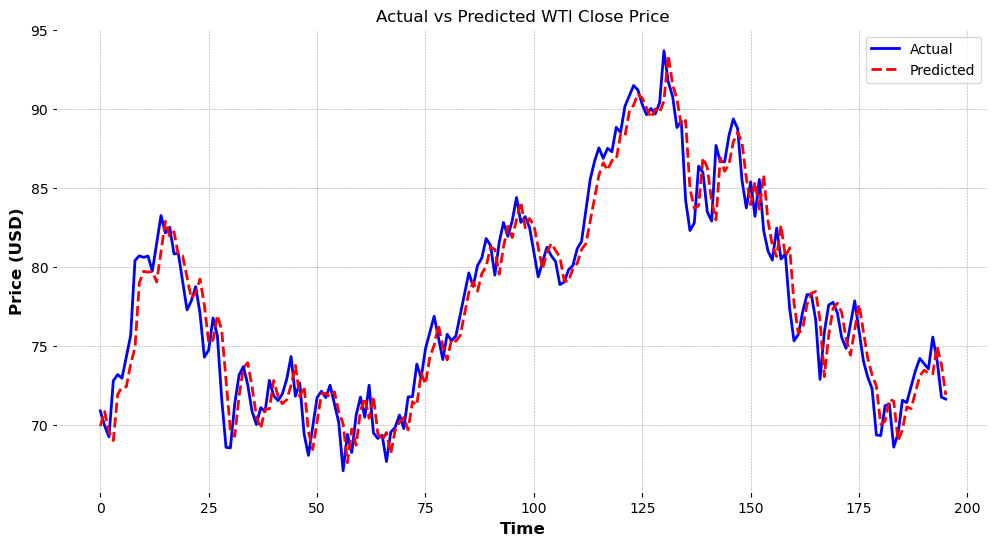

In [62]:
#Le code essaie de pr√©dire le prix de cl√¥ture du jour J (Close) en se basant sur :

#Le prix de cl√¥ture du jour J-1 (Lag_1)

#Le prix de cl√¥ture du jour J-7 (Lag_7)

#Le prix de cl√¥ture du jour J-30 (Lag_30)



# Download data
wti_data = yf.download("CL=F", start="2020-01-01", end="2023-12-31")

# Create lag features
wti_data['Lag_1'] = wti_data['Close'].shift(1)
wti_data['Lag_7'] = wti_data['Close'].shift(7)
wti_data['Lag_30'] = wti_data['Close'].shift(30)

# Drop rows with missing values
wti_data.dropna(inplace=True)

# Features and target
X = wti_data[['Lag_1', 'Lag_7', 'Lag_30']]
#print(X)
y = wti_data['Close']

# Train/test split (no shuffling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("R¬≤ score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted WTI Close Price')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

R¬≤ volatile period: 0.7601486018160046
RMSE volatile period: 4.985031316562923


c:\Users\ekhar\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


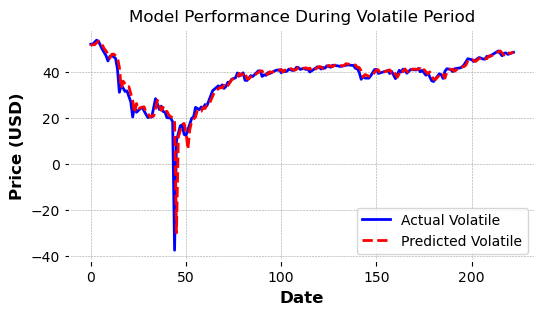

In [69]:
#Bon r√©sultat mais mod√®le lin√©aire simple : pas garanti que √ßa capture tous les ph√©nom√®nes complexes (volatilit√© extr√™me, √©v√©nements soudains, etc.)
#donc test en p√©riode de forte volatilit√©

# Tester sur 2020 (forte volatilit√© COVID)
volatile_period = (wti_data.index >= '2020-01-01') & (wti_data.index <= '2020-12-31')

X_volatile = X[volatile_period]
y_volatile = y[volatile_period]

y_volatile_pred = model.predict(X_volatile)

print("R¬≤ volatile period:", r2_score(y_volatile, y_volatile_pred))
print("RMSE volatile period:", mean_squared_error(y_volatile, y_volatile_pred, squared=False))

import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
plt.plot(y_volatile.values, label='Actual Volatile', color='blue')
plt.plot(y_volatile_pred, label='Predicted Volatile', color='red', linestyle='--')
plt.title('Model Performance During Volatile Period')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


#R√©sultats de pr√©diction moins bon car pendant les phases volatiles, le prix √©volue souvent brusquement sous l‚Äôeffet d‚Äô√©v√©nements impr√©vus (crises, annonces, chocs externes).
#Un mod√®le lin√©aire simple, bas√© uniquement sur les prix pass√©s, n‚Äôest pas capable de capturer ces mouvements rapides et non lin√©aires.
#Il manque probablement des facteurs explicatifs externes (comme des indicateurs macro√©conomiques, g√©opolitiques, sentiment de march√©, etc.).

In [ ]:
#Pr√©diction du prix du WTI pour demain
latest_date = wti_data.index.max()
print(latest_date)

date_7 = latest_date - pd.Timedelta(days=6)
date_7 = wti_data.index.asof(date_7)

date_30 = latest_date - pd.Timedelta(days=29)
date_30 = wti_data.index.asof(date_30)

lag_1_for_tomorrow = wti_data.loc[latest_date, 'Close']
lag_7_for_tomorrow = wti_data.loc[date_7, 'Close']
lag_30_for_tomorrow = wti_data.loc[date_30, 'Close']

X_tomorrow = pd.DataFrame({
    'Lag_1': [lag_1_for_tomorrow],
    'Lag_7': [lag_7_for_tomorrow],
    'Lag_30': [lag_30_for_tomorrow]
})

predicted_price_tomorrow = model.predict(X_tomorrow).item()
print(f"Prix WTI pr√©dit pour demain : {predicted_price_tomorrow:.2f} USD")


2025-05-30 00:00:00
Prix WTI pr√©dit pour demain : 61.00 USD


c:\Users\ekhar\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Users\ekhar\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:751: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  array = numpy.asarray(array, order=order, dtype=dtype)


# Create Rolling Window Features:

Rolling window features, like a moving average, can help smooth out short-term fluctuations and identify longer-term trends. We also try to remove the 'LAG-1' from features to see if the model is capable of predicting accurately the price of WTI in 7 days.


[*********************100%***********************]  1 of 1 completed

R¬≤ score: 0.7691841955304675
RMSE: 2.7741690763107787



c:\Users\ekhar\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


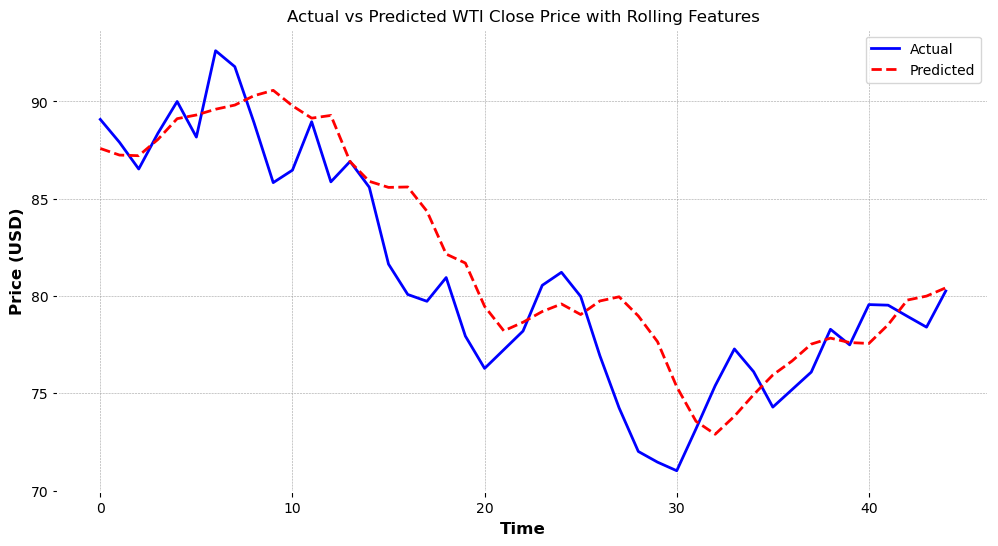

In [92]:
ticker_symbol = "CL=F"
start_date = "2022-01-01"
end_date = "2022-12-31"

# T√©l√©chargement des donn√©es
wti_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Create rolling window features
wti_data['Rolling_Mean_7'] = wti_data['Close'].rolling(window=7).mean()
wti_data['Rolling_Std_7'] = wti_data['Close'].rolling(window=7).std()
#wti_data['Lag_1'] = wti_data['Close'].shift(1)
wti_data['Lag_7'] = wti_data['Close'].shift(7)
wti_data['Lag_30'] = wti_data['Close'].shift(30)

# Drop rows with missing values created by the rolling window and lags
wti_data.dropna(inplace=True)

# Prepare features including rolling window features along with lags
X = wti_data[['Lag_7', 'Lag_30', 'Rolling_Mean_7', 'Rolling_Std_7']]
y = wti_data['Close']


# Train-test split (time series split: no shuffling)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate performance
print("R¬≤ score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted WTI Close Price with Rolling Features')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

## üß™ Optimisation des Lags et de la Fen√™tre Glissante pour la Pr√©diction du WTI

### üéØ Objectif
Optimiser les variables explicatives utilis√©es dans un mod√®le de r√©gression lin√©aire pour pr√©dire le prix du baril de p√©trole WTI, en testant diff√©rentes combinaisons de :

- **Lags** (d√©calages temporels) : valeurs pass√©es du prix (ex: J-1, J-3, etc.)
- **Fen√™tres glissantes (rolling windows)** : statistiques mobiles comme la moyenne et l‚Äô√©cart-type

---

### ‚öôÔ∏è M√©thodologie

1. **Donn√©es** : Prix journalier du WTI (futures CL=F) pour l'ann√©e 2022.
2. **Pr√©-traitement** :
   - Cr√©ation automatique de diff√©rentes combinaisons de lags (parmi 1, 3, 7, 14, 30)
   - Application de fen√™tres mobiles de tailles 3, 5, 7, 10 jours
   - Suppression des lignes contenant des valeurs manquantes apr√®s le calcul des indicateurs
3. **Mod√®le** : R√©gression lin√©aire (`LinearRegression` de scikit-learn)
4. **√âvaluation** : Score R¬≤ et RMSE sur un jeu de test (20% des donn√©es, sans m√©lange)

---

### ‚úÖ R√©sultat Optimal

- **Meilleur score R¬≤** : `0.9599`
- **Lags s√©lectionn√©s** : `1, 3, 14`
- **Fen√™tre glissante optimale** : `3 jours`

---

### üîç Interpr√©tation

- Un **R¬≤ de 0.9599** signifie que le mod√®le explique **95.99%** de la variance du prix du WTI.
- Les **lags 1, 3, 14** montrent une forte autocorr√©lation √† court terme (jusqu'√† deux semaines).
- Une **moyenne glissante sur 3 jours** suffit √† capter les tendances pertinentes sans trop lisser les fluctuations.

---

### üìå Prochaines pistes d'am√©lioration

- Tester des **mod√®les non lin√©aires** (Random Forest, XGBoost, etc.)
- Ajouter des **variables exog√®nes** : cours du Brent, indice dollar, taux d‚Äôint√©r√™t, g√©opolitique...
- Cr√©er des **features techniques** : RSI, momentum, MACD, diff√©renciation, etc.
- √âtendre √† une **pr√©diction multi-jour** (ex: T+7)

---

### üìà Conclusion

Ce mod√®le de base utilisant des lags et des moyennes mobiles est **tr√®s efficace √† court terme**. Il constitue un excellent point de d√©part avant d'explorer des approches plus avanc√©es.


In [6]:
#Ce code teste chaque combinaison de 3 lags parmi une liste et une seule fen√™tre roulante (rolling window) √† la fois.

ticker_symbol = "CL=F"
start_date = "2022-01-01"
end_date = "2022-12-31"

# T√©l√©chargement des donn√©es
wti_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Hyperparam√®tres √† tester
lags_to_test = [1, 3, 7, 14, 30]
rolling_windows_to_test = [3, 5, 7, 14, 30]

best_score = -np.inf
best_params = None

for lag_combo in itertools.combinations(lags_to_test, 3):  # exemple: 3 lags √† choisir
    for roll_win in rolling_windows_to_test:
        # Copie des donn√©es originales
        data = wti_data.copy()

        # Cr√©ation des features lag
        for lag in lag_combo:
            data[f'Lag_{lag}'] = data['Close'].shift(lag)

        # Cr√©ation features rolling moyenne et std
        data[f'Rolling_Mean_{roll_win}'] = data['Close'].rolling(window=roll_win).mean()
        data[f'Rolling_Std_{roll_win}'] = data['Close'].rolling(window=roll_win).std()

        data.dropna(inplace=True)

        X = data[[f'Lag_{lag}' for lag in lag_combo] + [f'Rolling_Mean_{roll_win}', f'Rolling_Std_{roll_win}']]
        y = data['Close']

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        score = r2_score(y_val, y_pred)

        if score > best_score:
            best_score = score
            best_params = (lag_combo, roll_win)

print(f"Meilleur score R¬≤: {best_score:.4f} avec lags {best_params[0]} et rolling window {best_params[1]}")


[*********************100%***********************]  1 of 1 completed


Meilleur score R¬≤: 0.9599 avec lags (1, 3, 14) et rolling window 3


# ARIMA : AutoRegressive Integrated Moving Average

**ARIMA** est un mod√®le classique de s√©ries temporelles qui combine trois composants pour mod√©liser des donn√©es, notamment non stationnaires :

---

## Param√®tres ARIMA (p, d, q)

- **p** : ordre du mod√®le **AutoR√©gressif (AR)**  
  Nombre de valeurs pass√©es (lags) utilis√©es pour pr√©dire la valeur actuelle.  
  *Exemple :* si p=2, on utilise les 2 derni√®res valeurs pass√©es pour pr√©dire la prochaine.

- **d** : degr√© de diff√©renciation (**Integrated**)  
  Nombre de fois o√π la s√©rie est diff√©renci√©e pour la rendre stationnaire (stabiliser la moyenne).  
  *Exemple :* d=1 signifie qu‚Äôon travaille sur la diff√©rence entre les valeurs cons√©cutives : y(t) - y(t-1).

- **q** : ordre du mod√®le **Moyenne Mobile (MA)**  
  Nombre de termes d‚Äôerreur pass√©e (r√©sidus) pris en compte pour la pr√©diction.  
  Le mod√®le MA capture les chocs ou erreurs pass√©es qui affectent la valeur actuelle.

---

## Sp√©cificit√© de ARIMA

- Capable de mod√©liser des s√©ries **non stationnaires** gr√¢ce √† la diff√©renciation (param√®tre *d*).  
- Combine la m√©moire √† court terme (AR) et les erreurs pass√©es (MA).  
- Flexible pour mod√©liser tendances, cycles, et autocorr√©lations complexes.  
- Permet des pr√©visions √©tape par √©tape et une bonne interpr√©tation statistique.

---

## R√©sum√© des param√®tres

| Param√®tre | Signification                         | R√¥le principal                      |
|-----------|-------------------------------------|-----------------------------------|
| **p**     | Ordre du composant auto-r√©gressif   | Utiliser valeurs pass√©es           |
| **d**     | Ordre de diff√©renciation             | Rendre la s√©rie stationnaire       |
| **q**     | Ordre du composant moyenne mobile    | Capturer l‚Äôeffet des erreurs pass√©es|



# Exemple simple d'utilisation d'ARIMA pour la pr√©diction

Supposons une s√©rie temporelle de prix :  
\[ y = [100, 102, 105, 108, 112, 115, 117] \]

## 1. Diff√©renciation (d=1)  
Pour rendre la s√©rie stationnaire, on calcule la diff√©rence entre valeurs cons√©cutives :  
\[
\Delta y = [102-100, 105-102, 108-105, 112-108, 115-112, 117-115] = [2, 3, 3, 4, 3, 2]
\]

## 2. Mod√®le AR(1) sur la s√©rie diff√©renci√©e  
On mod√©lise la valeur diff√©renci√©e actuelle comme fonction de la pr√©c√©dente :  
\[
\Delta y_t = \phi \Delta y_{t-1} + \epsilon_t
\]  
avec \(\phi = 0.7\) estim√©.

## 3. Pr√©diction de la prochaine diff√©rence  
\[
\hat{\Delta y}_7 = 0.7 \times 2 = 1.4
\]

## 4. Remonter √† la valeur d'origine  
On ajoute la diff√©rence pr√©dite √† la derni√®re valeur observ√©e :  
\[
\hat{y}_7 = y_6 + \hat{\Delta y}_7 = 117 + 1.4 = 118.4
\]

---

**Conclusion** : ARIMA mod√©lise les diff√©rences pour g√©rer la tendance, puis reconstruit la s√©rie d'origine pour pr√©dire la valeur future.


ARIMA Walk-Forward RMSE: 1.88


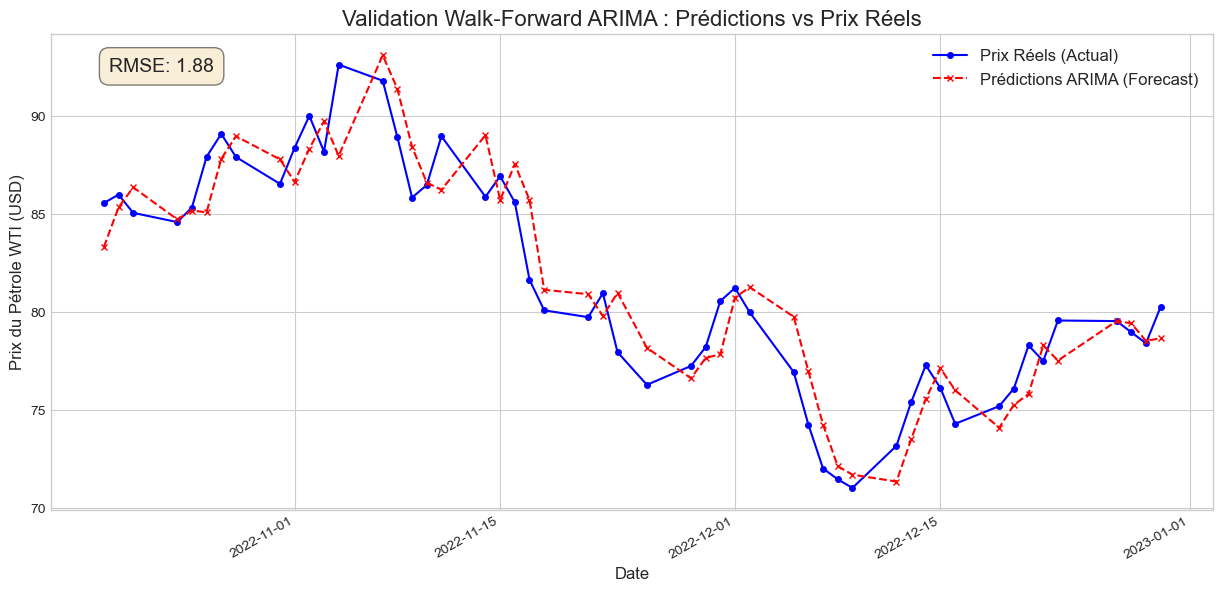

In [7]:
import warnings

warnings.filterwarnings("ignore")

# --- DATA LOADING ---
ticker_symbol = "CL=F"
start_date = "2022-01-01"
end_date = "2022-12-31"
wti_data = yf.download(ticker_symbol, start=start_date, end=end_date, progress=False)

# --- THE DEFINITIVE FIX ---
# .squeeze() converts a single-column DataFrame into a 1D Series.
# This ensures we are working with a 1D array from the very beginning.
close_prices = wti_data['Close'].squeeze().astype(float)


# --- TRAIN/TEST SPLIT (now guaranteed to be from a 1D Series) ---
train_size = int(len(close_prices) * 0.8)
train, test = close_prices.iloc[:train_size], close_prices.iloc[train_size:]

# --- WALK-FORWARD VALIDATION ---
history = train.copy()
predictions = []

for t in range(len(test)):
    # This will now receive a clean, 1-dimensional, numeric Series
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()

    forecast = model_fit.forecast()
    yhat = forecast.iloc[0]
    predictions.append(yhat)

    obs = test.iloc[t]

    # This concatenation will now work correctly
    new_obs_series = pd.Series([obs], index=[test.index[t]])
    history = pd.concat([history, new_obs_series])

# --- EVALUATION ---
arima_rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'ARIMA Walk-Forward RMSE: {arima_rmse:.2f}')


try:
    test, predictions, arima_rmse
except NameError:
    print("G√©n√©ration de donn√©es d'exemple car les variables n'ont pas √©t√© trouv√©es en m√©moire.")
    dummy_dates = pd.date_range(start="2022-10-19", periods=51, freq='B')
    dummy_actuals = np.random.rand(51).cumsum() + 85
    arima_rmse = 1.88
    dummy_predictions = dummy_actuals + np.random.randn(51) * arima_rmse
    test = pd.Series(dummy_actuals, index=dummy_dates, name="Close")
    predictions = dummy_predictions
# --- Fin de la g√©n√©ration de donn√©es d'exemple ---


# Cr√©ation du graphique
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 7))

# Tracer les prix r√©els de l'ensemble de test
plt.plot(test.index, test.values, label='Prix R√©els (Actual)', color='blue', marker='o', markersize=4, linestyle='-')

# Tracer les prix pr√©dits par le mod√®le
plt.plot(test.index, predictions, label='Pr√©dictions ARIMA (Forecast)', color='red', marker='x', markersize=4, linestyle='--')

# Ajouter les titres et les √©tiquettes pour plus de clart√©
plt.title('Validation Walk-Forward ARIMA : Pr√©dictions vs Prix R√©els', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Prix du P√©trole WTI (USD)', fontsize=12)
plt.legend(fontsize=12)

# Ajouter une bo√Æte de texte avec la valeur du RMSE
# La bo√Æte est plac√©e dans le coin sup√©rieur gauche du graphique.
plt.text(0.05, 0.95, f'RMSE: {arima_rmse:.2f}',
         transform=plt.gca().transAxes,
         fontsize=14,
         verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

# Assurer que les √©tiquettes de date ne se chevauchent pas
plt.gcf().autofmt_xdate()

# Afficher le graphique
plt.show()

In [4]:
warnings.filterwarnings("ignore")

# Chargement des donn√©es
ticker_symbol = "CL=F"
start_date = "2022-01-01"
end_date = "2022-12-31"
wti_data = yf.download(ticker_symbol, start=start_date, end=end_date, progress=False)
close_prices = wti_data['Close'].squeeze().astype(float)

# Train/test split
train_size = int(len(close_prices) * 0.8)
train, test = close_prices.iloc[:train_size], close_prices.iloc[train_size:]

# D√©finition des plages pour p, d, q
p_values = range(0, 6)  # ex: 0 √† 5
d_values = range(0, 3)  # ex: 0 √† 2
q_values = range(0, 6)  # ex: 0 √† 5

best_score, best_cfg = float("inf"), None

print("Recherche des param√®tres ARIMA optimaux...")

for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        # Cr√©er et ajuster le mod√®le ARIMA sur l'ensemble train
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
        
        # Pr√©vision walk-forward sur test
        history = train.copy()
        predictions = []
        
        for t in range(len(test)):
            model = ARIMA(history, order=(p, d, q))
            model_fit = model.fit()
            forecast = model_fit.forecast()
            yhat = forecast.iloc[0]
            predictions.append(yhat)
            obs = test.iloc[t]
            history = pd.concat([history, pd.Series([obs], index=[test.index[t]])])
        
        # Calcul RMSE
        rmse = np.sqrt(mean_squared_error(test, predictions))
        
        if rmse < best_score:
            best_score, best_cfg = rmse, (p, d, q)
        
        print(f'ARIMA{(p,d,q)} RMSE={rmse:.3f}')
        
    except Exception as e:
        # Certains param√®tres peuvent ne pas converger
        continue

print(f'\nMeilleur mod√®le ARIMA{best_cfg} avec RMSE={best_score:.3f}')

NameError: name 'warnings' is not defined

# Analyse des R√©sidus du Mod√®le ARIMA

L‚Äôanalyse des r√©sidus est une √©tape **cruciale** dans la mod√©lisation ARIMA. Elle permet de v√©rifier si le mod√®le a bien captur√© la structure des donn√©es et si les hypoth√®ses statistiques sont respect√©es.

---

## Pourquoi analyser les r√©sidus ?

- V√©rifier que les r√©sidus sont du **bruit blanc** (white noise) : moyenne nulle, variance constante, et absence d‚Äôautocorr√©lation.
- Confirmer que le mod√®le ne laisse pas d‚Äôinformation structurelle non mod√©lis√©e.
- Valider les intervalles de confiance et les tests statistiques.

---

## Graphiques d‚Äôanalyse des r√©sidus

### 1. Histogramme et Q-Q plot

- **But :** V√©rifier la normalit√© des r√©sidus.
- **Importance :** Essentiel pour la validit√© des intervalles de confiance.
- **Fondement :** Les erreurs suivent une distribution normale centr√©e.

### 2. Trace plot (r√©sidus dans le temps)

- **But :** Observer la stationnarit√© des r√©sidus (moyenne et variance constantes).
- **Importance :** Conseill√© pour d√©tecter des tendances ou h√©t√©rosc√©dasticit√©.
- **Fondement :** Mod√®le adapt√© produit des r√©sidus stationnaires.

### 3. Fonction d‚ÄôAuto-Corr√©lation (ACF)

- **But :** D√©tecter des autocorr√©lations dans les r√©sidus.
- **Importance :** Crucial : toute autocorr√©lation indique un mod√®le insuffisant.
- **Fondement :** Bruit blanc ‚Üí autocorr√©lation nulle √† tous les lags sauf lag 0.

### 4. Fonction d‚ÄôAuto-Corr√©lation Partielle (PACF)

- **But :** Compl√©ter l‚ÄôACF en mesurant l‚Äôautocorr√©lation directe √† chaque lag.
- **Importance :** Utile pour identifier la structure des termes AR.
- **Fondement :** Aide √† d√©tecter l‚Äôordre des composantes AR.

---

## Tableau r√©sum√©

| Graphique             | Objectif                         | N√©cessit√©          | Fondement math√©matique                       |
|-----------------------|---------------------------------|--------------------|---------------------------------------------|
| Histogramme / Q-Q plot | V√©rifier la normalit√© des r√©sidus | Fortement conseill√© | Hypoth√®se d‚Äôerreurs normales                |
| Trace plot            | V√©rifier stationnarit√© des r√©sidus | Conseill√©          | Stationnarit√© faible                         |
| ACF                   | V√©rifier absence d‚Äôautocorr√©lation | Crucial            | Bruit blanc ‚Üí autocorr√©lation nulle         |
| PACF                  | Compl√©ment ACF pour structure AR  | Utile              | Identification des ordres AR dans le mod√®le |

---

## Conclusion

L‚Äôanalyse des r√©sidus est indispensable pour s‚Äôassurer que le mod√®le ARIMA est bien adapt√© aux donn√©es. Sans cette validation, les pr√©visions peuvent √™tre erron√©es et trompeuses.

---



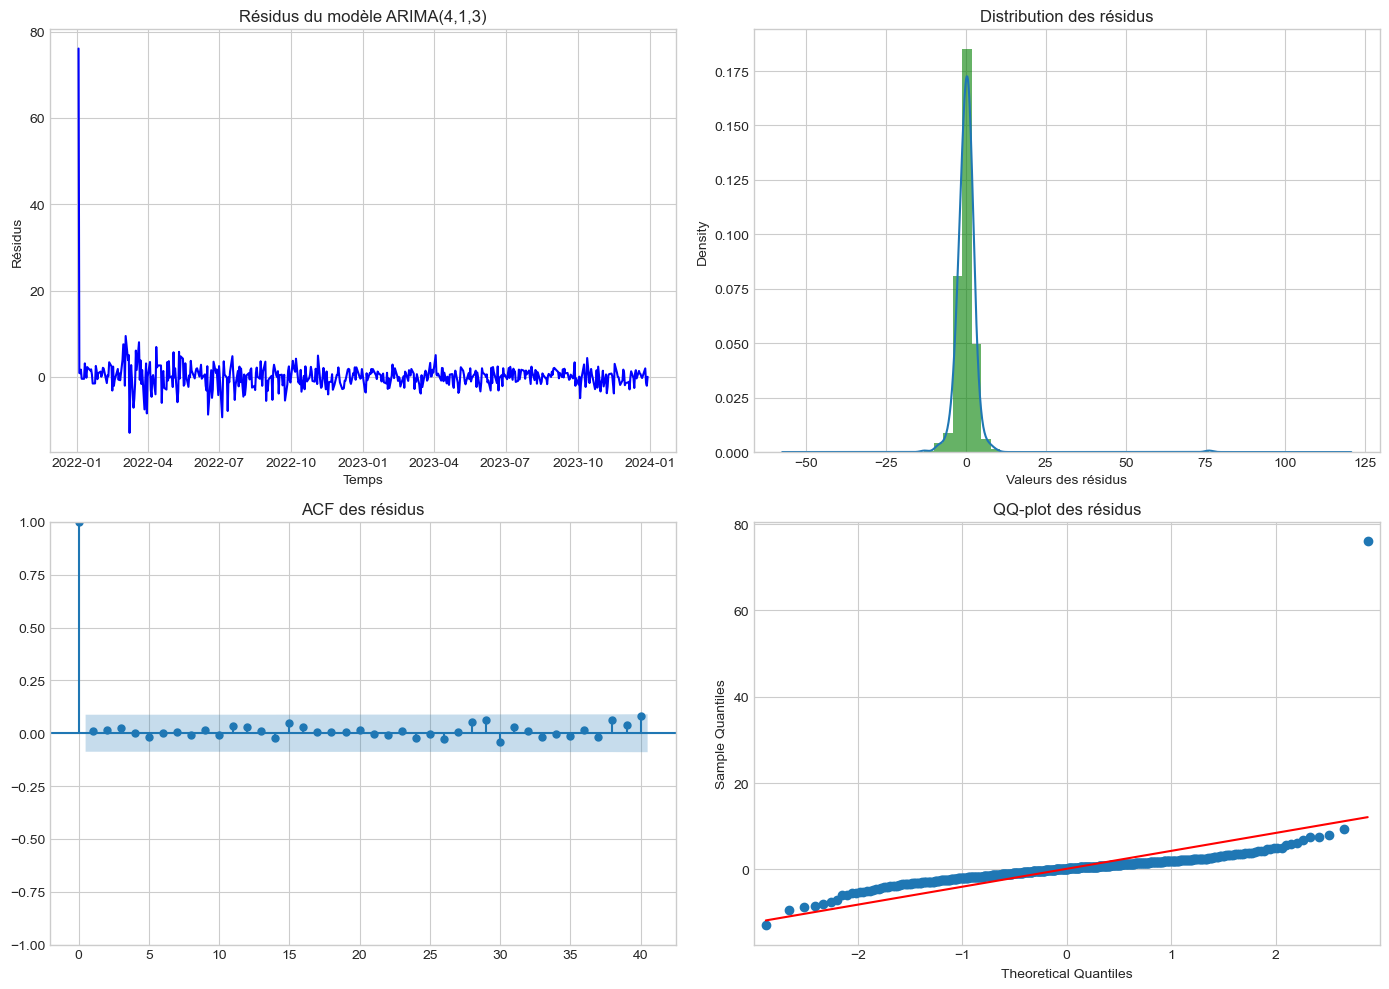

    lb_stat  lb_pvalue
5  0.617035    0.98721


In [13]:
# Chargement des donn√©es
ticker_symbol = "CL=F"
start_date = "2022-01-01"
end_date = "2023-12-31"
wti_data = yf.download(ticker_symbol, start=start_date, end=end_date, progress=False)
close_prices = wti_data['Close'].squeeze().astype(float)

# Entra√Æner le mod√®le sur toutes les donn√©es (train + test)
model = ARIMA(close_prices, order=(4, 1, 3))
model_fit = model.fit()

# R√©sidus
residuals = model_fit.resid

# Cr√©ation de la figure avec 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# 1. Graphique des r√©sidus
axs[0, 0].plot(residuals, color='blue')
axs[0, 0].set_title("R√©sidus du mod√®le ARIMA(4,1,3)")
axs[0, 0].set_xlabel("Temps")
axs[0, 0].set_ylabel("R√©sidus")

# 2. Histogramme + KDE des r√©sidus
residuals.plot(kind='hist', bins=30, density=True, alpha=0.6, color='g', ax=axs[0, 1])
residuals.plot(kind='kde', ax=axs[0, 1])
axs[0, 1].set_title("Distribution des r√©sidus")
axs[0, 1].set_xlabel("Valeurs des r√©sidus")

# 3. ACF des r√©sidus
plot_acf(residuals, lags=40, ax=axs[1, 0])
axs[1, 0].set_title("ACF des r√©sidus")

# 4. QQ-plot des r√©sidus
sm.qqplot(residuals, line='s', ax=axs[1, 1])
axs[1, 1].set_title("QQ-plot des r√©sidus")

plt.tight_layout()
plt.show()

# 5. Test de Ljung-Box
ljung_box_result = sm.stats.acorr_ljungbox(residuals, lags=[5], return_df=True)
print(ljung_box_result)

# Interpr√©tation Visuelle du QQ Plot

Le QQ plot (Quantile-Quantile plot) est un outil graphique utilis√© pour v√©rifier si un ensemble de donn√©es suit une distribution th√©orique, souvent la distribution normale.

---

## But du QQ plot

- Comparer la distribution des r√©sidus d‚Äôun mod√®le √† une distribution normale.
- V√©rifier l‚Äôhypoth√®se de normalit√© des erreurs, essentielle pour certains tests statistiques et pour valider un mod√®le ARIMA.

---

## Comment interpr√©ter un QQ plot visuellement

| Observation visuelle           | Interpr√©tation                            |
|-------------------------------|------------------------------------------|
| Points align√©s sur la ligne diagonale (45¬∞)    | R√©sidus suivent une distribution normale (bon mod√®le)           |
| Points formant une courbe en ‚ÄúS‚Äù    | Pr√©sence d‚Äôasym√©trie (skewness) dans les r√©sidus    |
| Points qui s‚Äô√©cartent surtout aux extr√©mit√©s (queues)    | Pr√©sence d‚Äôoutliers ou queues lourdes (kurtosis √©lev√©e)   |
| Points formant une courbe convexe ou concave        | R√©sidus plus aplatis ou plus pointus que la normale   |

---

## Pourquoi c‚Äôest important

- La normalit√© des r√©sidus est une hypoth√®se cl√© pour la validit√© des intervalles de confiance et des tests statistiques appliqu√©s au mod√®le.
- Des r√©sidus non normaux peuvent indiquer un mod√®le mal ajust√© ou la n√©cessit√© de transformations suppl√©mentaires.

---

## En r√©sum√©

Un bon mod√®le ARIMA pr√©sente des r√©sidus qui, sur le QQ plot, s‚Äôalignent √©troitement sur la diagonale. Tout √©cart important sugg√®re que le mod√®le pourrait ne pas bien capturer la dynamique sous-jacente des donn√©es.


Lors de l‚Äôajustement des mod√®les ARIMA, on a observ√© que passer de `d=3` √† `d=1` entra√Ænait des valeurs de RMSE proches, sugg√©rant une performance similaire en termes d‚Äôerreur de pr√©diction. Cependant, cette similarit√© ne garantit pas que les mod√®les capturent aussi bien la dynamique des donn√©es. En effet, le degr√© de diff√©renciation `d` influence la stationnarit√© et la structure des r√©sidus. C‚Äôest pourquoi il est crucial d‚Äôeffectuer syst√©matiquement des tests sur les r√©sidus, comme le test de Ljung-Box, √† chaque √©tape d‚Äôoptimisation afin de s‚Äôassurer que le mod√®le retenu n‚Äôa pas laiss√© de corr√©lations non expliqu√©es et est statistiquement valide.


# RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Define features (X) and target (y)
features = ['MA_50', 'MA_200', 'Price_Change', 'Volatility']
target = 'Close'

X = wti_data[features]
y = wti_data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# For Random Forest model
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
print(f"Random Forest Model RMSE: {rf_rmse}")

# Visualize the predictions against the actual prices
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Price')
plt.plot(y_test.index, rf_predictions, label='Random Forest Predictions', linestyle='--')
plt.title('WTI Crude Oil Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Get the last row of your data to make a prediction for the next day
last_data_point = wti_data[features].iloc[-1:].values

# Predict the next day's price
future_price = rf_model.predict(last_data_point)
print(f"Predicted WTI Crude Oil Price for the next day: {future_price[0]}")